## Step 1: Load Libraries and Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split



# Load the dataset
df = pd.read_csv("../data/log_sample.csv")
df.head()


,timestamp,src_ip,dst_ip,protocol,packet_count,byte_count,duration_sec,flags,label
0,2025-01-01 00:00:00,192.168.0.81,10.0.0.2,TCP,18,13548,0.56,FIN,benign
1,2025-01-01 00:01:00,192.168.0.115,10.0.0.32,ICMP,16,13599,0.49,PSH,DoS
2,2025-01-01 00:02:00,192.168.0.92,10.0.0.65,UDP,20,8186,6.40,SYN,DoS
3,2025-01-01 00:03:00,192.168.0.48,10.0.0.217,ICMP,16,5319,0.96,SYN,benign
4,2025-01-01 00:04:00,192.168.0.247,10.0.0.146,ICMP,17,4770,3.02,URG,benign


## Step 2: Data Preprocessing

In [15]:
# Encode categorical features
df_encoded = df.copy()
le = LabelEncoder()
df_encoded['protocol'] = le.fit_transform(df_encoded['protocol'])
df_encoded['flags'] = le.fit_transform(df_encoded['flags'])
df_encoded['label'] = df_encoded['label'].map({'benign': 0, 'DoS': 1})

# Drop timestamp and IPs (not useful in clustering/classification for now)
df_encoded = df_encoded.drop(columns=["timestamp", "src_ip", "dst_ip"])
df_encoded.head()


,protocol,packet_count,byte_count,duration_sec,flags,label
0,1,18,13548,0.56,1,0
1,0,16,13599,0.49,2,1
2,2,20,8186,6.40,4,1
3,0,16,5319,0.96,4,0
4,0,17,4770,3.02,5,0


## Step 3: Clustering with K-Means

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=["label"]))

kmeans = KMeans(n_clusters=2, random_state=42)
df_encoded["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

# Compare with actual labels
pd.crosstab(df_encoded['label'], df_encoded['cluster_kmeans'], rownames=['Actual'], colnames=['Cluster'])


Cluster,0,1
Actual,,
0,424,402
1,95,79


## Step 4: Classification with Random Forest

In [17]:
X = df_encoded.drop(columns=["label", "cluster_kmeans"])
y = df_encoded["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


Confusion Matrix:
 [[240   0]
 [ 58   2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89       240
           1       1.00      0.03      0.06        60

    accuracy                           0.81       300
   macro avg       0.90      0.52      0.48       300
weighted avg       0.84      0.81      0.73       300

ROC AUC Score: 0.5615972222222221


## Step 5: Evaluation ROC Curve, Confusion Matrix, Metrics Summary

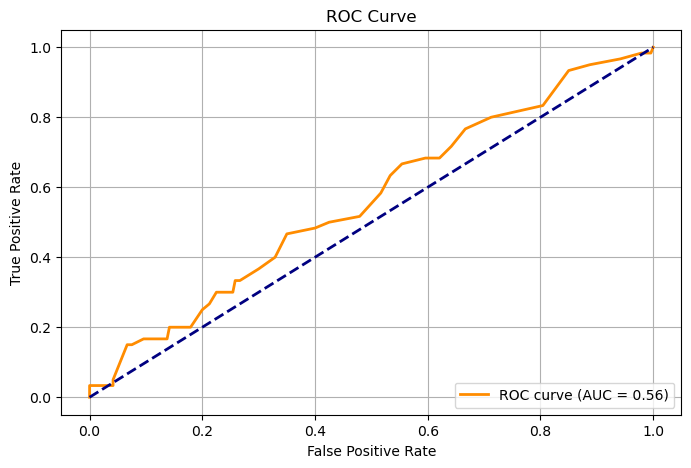

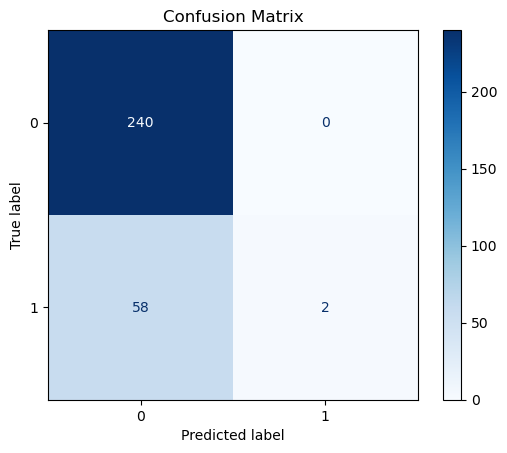

In [18]:
# 📊 Evaluation: ROC Curve, Confusion Matrix, Metrics Summary
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# ROC Curve
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


## 📊 Pipeline Diagram: Visual Overview

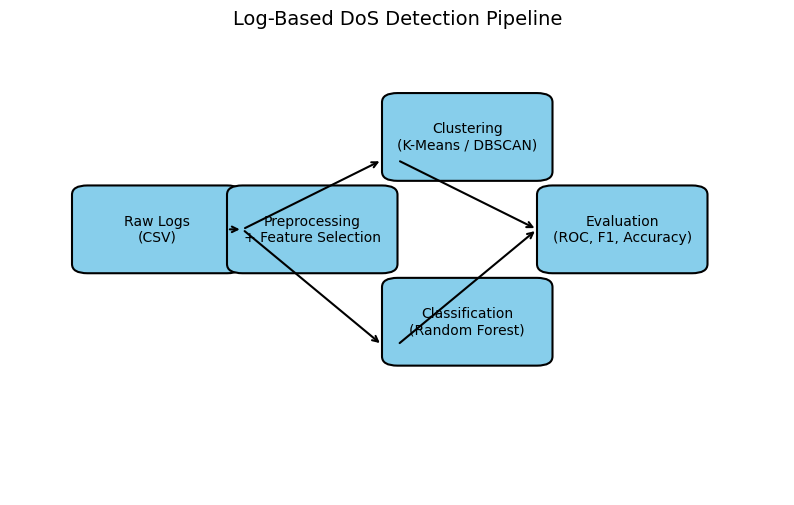

In [19]:
# 📊 Pipeline Diagram: Visual Overview
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Define steps and coordinates
steps = [
    ("Raw Logs\n(CSV)", (0.1, 0.5)),
    ("Preprocessing\n+ Feature Selection", (0.3, 0.5)),
    ("Clustering\n(K-Means / DBSCAN)", (0.5, 0.7)),
    ("Classification\n(Random Forest)", (0.5, 0.3)),
    ("Evaluation\n(ROC, F1, Accuracy)", (0.7, 0.5)),
]

# Draw boxes
for text, (x, y) in steps:
    ax.add_patch(mpatches.FancyBboxPatch((x, y), 0.18, 0.15,
                                         boxstyle="round,pad=0.02",
                                         fc="skyblue", ec="black", lw=1.5))
    ax.text(x + 0.09, y + 0.075, text, ha='center', va='center', fontsize=10)

# Arrows between steps
arrows = [
    ((0.28, 0.575), (0.3, 0.575)),
    ((0.3, 0.575), (0.48, 0.725)),
    ((0.3, 0.575), (0.48, 0.325)),
    ((0.5, 0.725), (0.68, 0.575)),
    ((0.5, 0.325), (0.68, 0.575)),
]

arrow_style = dict(arrowstyle="->", lw=1.5, color="black")
for start, end in arrows:
    ax.annotate("", xy=end, xytext=start, arrowprops=arrow_style)

plt.title("Log-Based DoS Detection Pipeline", fontsize=14)
plt.show()
